# Preparation
### Setup your own variables

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = str(0) # which gpu
workplace = os.path.join(os.environ["HOME"], "mixmo-pytorch") # where is your code
checkpointplace = os.path.join(os.environ["HOME"], "checkpoints") # where are your checkpoints
dataplace = "/data" # parent folder where is your cifar-100 dataset

### Import standard librairies and mixmo


In [2]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
import torch
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append(workplace)
from mixmo.loaders import get_loader
from mixmo.learners.learner import Learner
from mixmo.utils import (misc, visualize)

# Load pretrained networks

## Set configuration

CIFAR-100 dataset with:
- WideResNet-28-10 network architecture
- `M=2` subnetworks
- Cut-MixMo mixing block (patch mixing) with probability `p=0.5`
- Standard data augmentation (padding, cropping, flipping)
- batch repetition to `b=4`

In [3]:
config_name = "cifar100_wrn2810-2_cutmixmo-p5_standard_bar4"

We simply need to form a proper config dictionary and the correct checkpoint path

In [4]:
# path to the config describing the dataset, the learning strategy and the network 
config_path = os.path.join(
    workplace,
    "config/cifar100/exp_"+ config_name + ".yaml"
)
config_args = misc.load_config_yaml(config_path)

[Checkpoint](https://drive.google.com/file/d/1vxJFKuO5RSH9XcA2aSYUMHCrtD6pDyMA/view?usp=sharing) to be downloaded in folder `checkpointplace`

In [5]:
# path to the pretrained checkpoint
checkpoint = os.path.join(checkpointplace, "checkpoint_"+ config_name + ".ckpt")

In [6]:
# additional arguments
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tempscale = False
corruptions = False

## Load dataset

We load the dataset through a dloader object that takes care of the data loading, augmentation and input formatting steps

In [7]:
dloader = get_loader(
    config_args, split_test_val=tempscale, dataplace=dataplace, corruptions=corruptions
)

Files already downloaded and verified
Files already downloaded and verified


2021-04-07 11:06:03,105 pascal mixmo.loaders.abstract_loader[3854932] WARNING No validation loader


## Load learner

We now build the learner object that wraps both the model, optimizer and the already built loader objects. Training is performed through methods of this learner object.

In [8]:
learner = Learner(
    config_args=config_args,
    dloader=dloader,
    device=device,
)

2021-04-07 11:06:03,112 pascal mixmo.networks[3854932] WARNING Loading network: wideresnetmixmo
2021-04-07 11:06:15,121 pascal mixmo.networks.resnet[3854932] WARNING Features dimension: 640
2021-04-07 11:06:17,680 pascal mixmo.core.loss[3854932] INFO Using loss: {'name': 'soft_cross_entropy', 'display_name': 'ce0', 'coeff': 1, 'input': 'logits_0', 'target': 'target_0'} with name: ce0
2021-04-07 11:06:17,681 pascal mixmo.core.loss[3854932] INFO Using loss: {'name': 'soft_cross_entropy', 'display_name': 'ce1', 'coeff': 1.0, 'input': 'logits_1', 'target': 'target_1'} with name: ce1
2021-04-07 11:06:17,682 pascal mixmo.core.loss[3854932] DEBUG Skip loss: {'name': 'soft_cross_entropy', 'display_name': 'ce2', 'coeff': 0, 'input': 'logits_2', 'target': 'target_2'}
2021-04-07 11:06:17,683 pascal mixmo.core.loss[3854932] WARNING Set l2 regularization on WideResNetMixMo
2021-04-07 11:06:17,684 pascal mixmo.core.optimizer[3854932] INFO Using optimizer sgd with params {'lr': 0.0125, 'momentum': 0.

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [2, 16, 32, 32]             432
            Conv2d-2            [2, 16, 32, 32]             432
       BatchNorm2d-3            [2, 16, 32, 32]              32
            Conv2d-4           [2, 160, 32, 32]          23,040
       BatchNorm2d-5           [2, 160, 32, 32]             320
            Conv2d-6           [2, 160, 32, 32]         230,400
            Conv2d-7           [2, 160, 32, 32]           2,560
         WideBasic-8           [2, 160, 32, 32]               0
       BatchNorm2d-9           [2, 160, 32, 32]             320
           Conv2d-10           [2, 160, 32, 32]         230,400
      BatchNorm2d-11           [2, 160, 32, 32]             320
           Conv2d-12           [2, 160, 32, 32]         230,400
        WideBasic-13           [2, 160, 32, 32]               0
      BatchNorm2d-14           [2, 160,

## Load checkpoint

In [9]:
learner.load_checkpoint(checkpoint, include_optimizer=False)

# Observing feature separation

## Checking separation of filter weights in input encoders

We start by retrieving the weights of the network and only keeping the filter weights of the two input encoders

In [10]:
# select all parameters
list_parameters = list(learner.model_wrapper.network.named_parameters())

# filter only first convolution layers
list_conv1_weights = [
    params[1] for params in list_parameters
    if "conv" in params[0] and "weight" in params[0] and 'list_conv1' in params[0]]
assert len(list_conv1_weights) == 2

# compute the L1 norm by filter
list_conv1_l1 = [conv1_weights.data.cpu().abs().sum(dim=(1,2,3)).view(-1) for conv1_weights in list_conv1_weights]

We can then just retrieve the L1-norm of the conv1 filters and plot them, cf Figure 4.a in paper

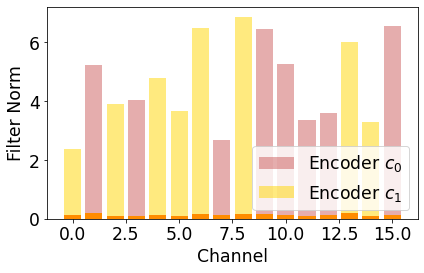

In [11]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=False, figsize=(6, 3.9))
colors = ["indianred", "gold"]
for k in range(2):
    var_activations = list_conv1_l1[k]
    ax1.bar([i for i in range(16)], var_activations, alpha=.5, label="Encoder $c_{}$".format(k), color=colors[k])
    
var_min = [min(list_conv1_l1[0][i], list_conv1_l1[1][i]) for i in range(16)]
ax1.bar([i for i in range(16)], var_min, alpha=1, color="darkorange")
 
ax1.tick_params(axis='both', which='major', labelsize="xx-large")
ax1.set_xlabel("Channel", fontsize="xx-large")
ax1.set_yticks([0, 2, 4, 6])
ax1.set_ylabel("Filter Norm", fontsize="xx-large")
ax1.legend(prop={'size':"xx-large"}, loc='lower right')

plt.tight_layout()
plt.show()

## Checking overall weights in the core network

It is also possible to check how many of the filter are "active" in the core layers of the model, with "active" simply denoting filters with fairly significant L1-norm in their layers. We consider threshold 20, 30, 40 and 50% in the main paper.

In [12]:
# filter only convolution layers in core network
list_convlayer_weights = [
    params[1] for params in list_parameters
    if "conv" in params[0] and "weight" in params[0] and 'list_conv1' not in params[0]
]
# compute the L1 norm by filter
list_convlayer_l1_byfilter = [convlayer_weights.data.cpu().abs().sum(dim=(1,2,3)).view(-1) for convlayer_weights in list_convlayer_weights]

We compute the proportion of active filters at several activity thresholds, cf Table 7 in paper with Cut-MixMo and w=10

In [13]:
list_convlayer_norm_byfilter = [convlayer_l1/convlayer_l1.max() for convlayer_l1 in list_convlayer_l1_byfilter]
for threshold in [0.2, 0.3, 0.4, 0.5]:
    prop = np.mean([(convlayer_norm>threshold).float().mean().numpy() for convlayer_norm in list_convlayer_norm_byfilter])
    print(f"Active beyond threshold {threshold}: {prop*100:.4}%")

Active beyond threshold 0.2: 98.46%
Active beyond threshold 0.3: 98.16%
Active beyond threshold 0.4: 96.82%
Active beyond threshold 0.5: 92.38%
